<font size="5">Tarea 2: Panel data</font>

### Franco Díaz - Nicolás Vallejos

In [1]:
# Importamos las librerías necesarias para el desarrollo de la tarea

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
import linearmodels.panel as lmp
import seaborn as sns

%matplotlib inline

Las variables con las que trabajaremos tienen la siguiente descripcion:

- INID: identificador unico
- wave: periodo de la encuesta (1-3)
- cesd: puntaje en la escala de salud mental (0-30)
- child: numero de hijos
- drinkly: bebio alcohol en el ultimo mes (binario)
- hrsusu: horas promedio trabajo semanal
- hsize: tamano del hogar
- intmonth: mes en que fue encuestado/a (1-12)
- married: si esta casado/a (binario)
- retired: si esta pensionado/a (binario)
- schadj: años de escolaridad
- urban: zona urbana (binario)
- wealth: riqueza neta (miles RMB)
- age: edad al entrar a la encuesta (no varia entre periodos)

**Es importante recalcar que a menor puntaje de escala de salud mental, es mejor la salud del encuestado.**





## 1. Se construye la estructura de panel

Al momento de leer directamente la información contenida en el archivo charls.csv se pudo notar que el código no se ejecutaba de manera correcta al querer formar la estructura de panel, por lo que al analizar en profundidad la estructura del archivo que contenía la data se pudo observar en primer lugar que la variable "drinkly" estaba en un formato distinto al requerido, ya que esta se mostraba tal y como se detalla a continuación: "0.None, 1.Yes, .m:missing" (debiendo ser una variable binaria), lo que explica el motivo por el cual se generaron problemas de lectura por parte de python. 

Ahora en segundo lugar, se tiene que desde el dato número 10.056 en adelante los identificadores únicos son tan grandes que no se diferencian unos de otros en ciertos casos, lo que también genera problemas en los resultados posteriores que se obtienen de la aplicación de ciertos modelos de análisis. 

Es por esto que se realizan modificaciones al archivo original con la finalidad de evitar estos errores de lectura y de resultados, donde se reemplazaron los identificadores únicos por una secuencia númerica ascendente que va desde el número 1 al 11.457, lo cual fue posible debido a que el número de periodos por cada ID se encuentran en la misma proporción (esto se realiza para evitar que los encuestados compartan identificadores) y se cambió la estructura de la variable drinkly, convirtiendola en una variable numérica y eliminando los datos que contengan información faltante/missing, para que de esta forma pueda cumplir con su cualidad de variable binaria.

Además, se agregaron variables dummy al modelo para poder estudiar los efectos del tiempo sobre las variables de interés.

El proceso detallado anteriormente se lleva a cabo a continuación:

In [2]:
# Leemos la data a partir del archivo charls.csv
charls = pd.read_csv('../charls.csv')
charls.dropna(inplace=True)
charls.reset_index(drop=True, inplace=True)

#Creación de variables Dummy

x_i_2=[]
x_i_3=[]
for i in range(len(charls)):
        if charls['wave'][i] == 1:
            x_i_2.append(0)
            x_i_3.append(0)
        if charls['wave'][i] == 2:
            x_i_2.append(1)
            x_i_3.append(0)
        if charls['wave'][i] == 3:
            x_i_2.append(0)
            x_i_3.append(1)

charls.insert(15,"x_i_2", x_i_2, allow_duplicates=False)
charls.insert(16,"x_i_3", x_i_3, allow_duplicates=False)

# Se reemplazan los ID's por una secuencia ascendente (de 1 a 11.457)

k=1
count=0
for i in range(len(charls)):
    if count<3:
        charls["inid"][i]=k
        count+=1
    else:
        count=1
        k+=1
        charls["inid"][i]=k
    
# Se realiza un cambio a la variable drinkly para pasarla de objeto a dato numérico

for i in range(len(charls)):
    if charls['drinkly'][i] == '0.None':
        charls['drinkly'][i] = 0;
    elif charls['drinkly'][i] == '1.Yes':
        charls['drinkly'][i] = 1;
    else:
        charls['drinkly'][i] = 2;
        
# Se crea una lista de ID's con drinkly missing (o faltante)

clear=[]
for i in range(len(charls)):
    if charls["drinkly"][i]==2:
        #print(i)
        #print(charls["drinkly"][i])
        #x=charls.index(2)
        aux=charls["inid"][i]
        #print(aux)
        clear.append(aux)
        #print(clear)

        
# Utilizando la lista anterior se eliminan de la data los datos con información incompleta

for i in range(len(clear)):
    charls=charls.loc[charls["inid"]!=clear[i],:]
    
  
charls['drinkly'] = pd.to_numeric(charls['drinkly'])

# Se construyen las variables con las que trabajaremos

X=charls[['child','drinkly','female','hrsusu','hsize','intmonth','married','retired','schadj','urban','wealth','age',"x_i_2","x_i_3"]]
Xm=(X.groupby(charls['inid']).transform('mean'))
Xid=charls[['inid','wave','cesd','child','drinkly','female','hrsusu','hsize','intmonth','married','retired','schadj','urban','wealth','age',"x_i_2","x_i_3"]]
Xc=pd.DataFrame(np.c_[Xid, Xm], columns=['inid','wave','cesd','child','drinkly','female','hrsusu','hsize','intmonth','married','retired','schadj','urban','wealth','age',"x_i_2","x_i_3",'mchild','mdrinkly','mfemale','mhrsusu','mhsize','mintmonth','mmarried','mretired','mschadj','murban','mwealth',"mage","mx_i_2","mx_i_3"])

# Se construye la estructura de panel
Xc = Xc.set_index(["inid","wave"])
charls.describe()


C:\Users\nico4\AppData\Local\Temp\ipykernel_13364\3991418886.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charls["inid"][i]=k
C:\Users\nico4\AppData\Local\Temp\ipykernel_13364\3991418886.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charls["inid"][i]=k
C:\Users\nico4\AppData\Local\Temp\ipykernel_13364\3991418886.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charls['drinkly'][i] = 0;
C:\Users\nico4\AppData\Local\Te

,cesd,child,drinkly,female,hrsusu,hsize,inid,intmonth,married,retired,schadj,urban,wave,wealth,age,x_i_2,x_i_3
count,34320.000000,34320.000000,34320.000000,34320.000000,34320.00000,34320.000000,34320.000000,34320.000000,34320.000000,34320.000000,34320.000000,34320.000000,34320.000000,3.432000e+04,34320.000000,34320.000000,34320.000000
mean,8.172611,2.707867,0.331381,0.537937,27.96411,3.441638,5730.483392,7.524446,0.874592,0.283974,4.678846,0.356119,2.000000,9.906338e+03,58.222727,0.333333,0.333333
std,6.184187,1.399603,0.470717,0.498566,28.27261,1.702819,3308.151372,0.915903,0.331186,0.450931,3.857980,0.478858,0.816508,9.744097e+04,9.153577,0.471411,0.471411
min,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2.110050e+06,16.000000,0.000000,0.000000
25%,3.000000,2.000000,0.000000,0.000000,0.00000,2.000000,2865.750000,7.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,51.000000,0.000000,0.000000
50%,7.000000,2.000000,0.000000,1.000000,21.00000,3.000000,5732.500000,7.000000,1.000000,0.000000,4.000000,0.000000,2.000000,4.000000e+02,58.000000,0.000000,0.000000
75%,12.000000,3.000000,1.000000,1.000000,54.00000,4.000000,8595.250000,8.000000,1.000000,1.000000,8.000000,1.000000,3.000000,5.000000e+03,64.000000,1.000000,1.000000
max,30.000000,11.000000,1.000000,1.000000,168.00000,16.000000,11457.000000,12.000000,1.000000,1.000000,18.000000,1.000000,3.000000,9.902500e+06,97.000000,1.000000,1.000000


### 1.1 Se analiza la correlación entre variables

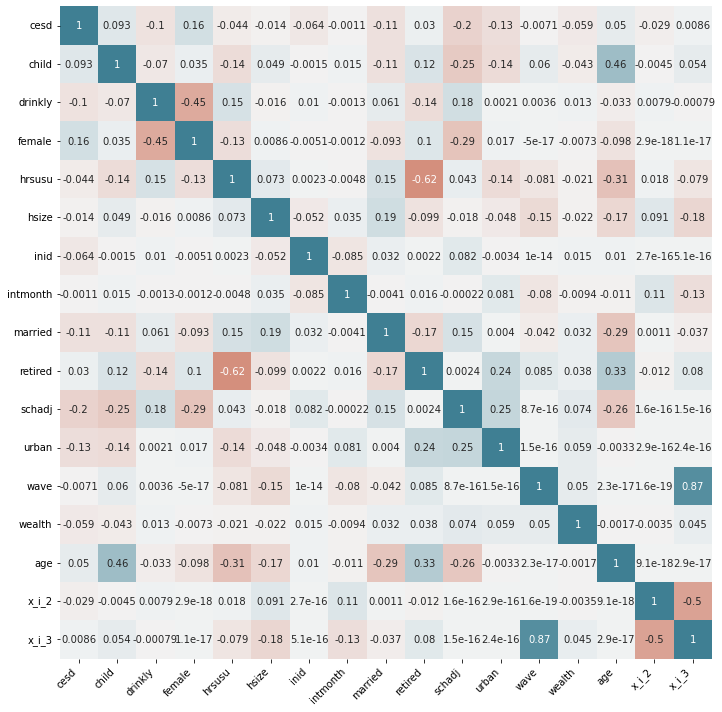

In [3]:
corr_matrix = charls.select_dtypes(include=['int', 'float']).corr(method='pearson')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))

sns.heatmap(corr_matrix,annot= True,cbar= False,annot_kws = {"size": 10},vmin=-1,vmax=1,center=0,cmap=sns.diverging_palette(20, 220, n=200),square=True,ax= ax)

ax.set_xticklabels(ax.get_xticklabels(),rotation = 45,horizontalalignment = 'right',)

ax.tick_params(labelsize = 10)

## 2. Pooled OLS

Se aplica el modelo de homogeneidad total o regresión agrupada (Pooled), el cual consiste en la aplicación de un modelo de regresión lineal clásico para el caso de datos de panel. Además, el término "regresión agrupada" hace referencia al hecho de que este modelo ignora que la estructura de los datos sea de panel.

Para este modelo se tomó como variable dependiente el "puntaje en la escala de salud mental" o "cesd" y como variables dependientes "child, drinkly, female, hrsusu, hsize, intmonth, married, retired, schadj, urban, wealth, age y las variables de tiempo x2 y x3". 

In [4]:
y=Xc['cesd']
X=Xc[['child','drinkly','female','hrsusu','hsize','intmonth','married','retired','schadj','urban','wealth','age',"x_i_2","x_i_3"]]
X=sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   cesd   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     189.6
Date:                Wed, 05 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:34:45   Log-Likelihood:            -1.0995e+05
No. Observations:               34320   AIC:                         2.199e+05
Df Residuals:                   34305   BIC:                         2.201e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8931      0.438     24.884      0.0

In [5]:
model=lmp.PooledOLS(y,X)
OLS=model.fit(cov_type="robust")
print(OLS)

                          PooledOLS Estimation Summary                          
Dep. Variable:                   cesd   R-squared:                        0.0718
Estimator:                  PooledOLS   R-squared (Between):              0.1061
No. Observations:               34320   R-squared (Within):               0.0033
Date:                Wed, Oct 05 2022   R-squared (Overall):              0.0718
Time:                        17:34:46   Log-likelihood                -1.099e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      189.58
Entities:                       11440   P-value                           0.0000
Avg Obs:                       3.0000   Distribution:                F(14,34305)
Min Obs:                       3.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             186.82
                            

### 2.1 Interpretación de resultados Pooled OLS

Para ambos modelos estimados se tiene que los parámetros significativos son: child, drinkly, female, hsize, married, retired, schadj, urban, wealth, age, x2 y x3.

Si bien el modelo ejecutado con linearmodels permite hacer que los errores estándar sean robustos (es decir que la matriz acepta heterocedasticidad) no existe una gran diferencia entre ambos modelos, lo que se ve evidenciado en la poca variación de los coeficientes de los parámetros estimados, como también las variables significativas, las cuales son las mismas para ambos casos. Además, al analizar el p-value podemos notar que las variables hacen un buen ajuste al modelo.

Analizando las salidas de ambos modelos se presenta la interpretación de las variables en relación al puntaje en la escala de salud mental de la población china:

1) Podemos observar que la mayoría de los factores son significativos a excepción del mes en el que se encuesta a las personas (intmonth).

2) En promedio se tiene que existe de base una constante de 10 en el puntaje de salud mental sin considerar ninguna de las otras variables.

3) la interpretación de las variables a partir de sus coeficientes se detalla a continuación:
- Al aumentar el número de hijos en 1 aumenta el puntaje en la escala de salud mental un 0,18.
- El hecho de que una persona haya bebido en el mes que ha sido encuestado en promedio hace que mejore su puntaje en la escala de salud mental.
- Se puede observar también que en promedio las mujeres tienen una peor salud mental que los hombres, dado que el hecho de que la encuestada sea mujer hace que presente un 1.3 puntos más en promedio que el hombre.
- Tenemos también que el mes donde fue encuestado tampoco resulta relevante para el modelo, ya que no logra explicar de manera clara la variación en el puntaje de la escala de salud mental.
- Por otro lado se tiene que el tamaño del hogar de residencia si es significativo al 95% de confianza, pero tiene un efecto muy pequeño en el puntaje de la escala de salud mental y no sería una variable a considerar para representar la salud mental de la población en general.
- En base a los resultados del modelo se tiene que en promedio las horas trabajadas semanales no son significativas para explicar el puntaje en la escala de salud mental de los ciudadanos chinos.
- Las personas casadas presentan una mejor salud mental que aquellas personas que viven solas, los resultados del modelo indican que una persona casada mejora su salud mental en 2 puntos en base a la encuesta.
- La variable "retired" también es significativa para el modelo y nos indica que en promedio los ciudadanos chinos retirados presentan una peor salud mental que aquellos que no.
- Mientras más educación posee el encuestado este tiene una mejor salud mental, aunque el efecto no es tan grande puede verse una disminución. En base a los resultados obtenidos en el modelo, la población en promedio por cada 5 años de escolaridad adicional mejora su puntaje en la escala de salud mental (disminuye en 1 punto).
- Las personas que viven en zonas urbanas en promedio presentan una mejor salud mental que los que viven en zonas rurales.
- En cuanto a la riqueza podemos ver que esta es significativa, sin embargo, su efecto es pequeño y casi despreciable, ya que según el parámetro estimado por cada mil millones de RMB adicionales de riqueza se tendrá en promedio una mejora en el puntaje de la encuesta de 2,526 puntos. Donde lo que puede estar pasando es que un grupo pequeño de familias adineradas muevan este parámetro. 
- La edad resulta significativa, y a medida que aumenta la edad en promedio va mejorando la salud mental. Sin embargo, estos efectos en general son minúsculos.
- Para las variables de tiempo tenemos que los efectos de los periodos 2 y 3 con respecto al periodo 1 son significativos, esto quiere decir que para el 2do periodo en promedio la salud mental en general mejora de acuerdo a los resultados de la encuesta, lo cual tiene relación con la edad y si es que ya se encuentran retirados y jubilados.




## 3. Fixed Effects 

Ahora se pasa a la aplicación del modelo de efectos fijos o Fixed Effects, el cual tal y como su nombre lo indica se caracteriza por hacer que los efectos de las variables se mantengan fijos a través del tiempo, lo que a diferencia del modelo de regresión agrupada permite una comparación individual para cada uno de los datos, es decir, una comparación de individuos contra sí mismos. Es importante notar que este modelo implica menos suposiciones sobre el comportamiento de los residuos.

Para la ejecución de este modelo se consideraron las mismas variables que para el modelo Pooled, pero debido a que algunas de estas presentan un efecto absorvente (son completamente colineales) se retiraron del modelo mediante el comando "drop_absorbed=true".

In [6]:
X=Xc[['child','drinkly','female','hrsusu','hsize','intmonth','married','retired','schadj','urban','wealth','age']]
X=sm.add_constant(X)
model=lmp.PanelOLS(y,X, entity_effects=True, drop_absorbed=True)
fe=model.fit(cov_type="robust")
print(fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                   cesd   R-squared:                        0.0034
Estimator:                   PanelOLS   R-squared (Between):              0.0194
No. Observations:               34320   R-squared (Within):               0.0034
Date:                Wed, Oct 05 2022   R-squared (Overall):              0.0140
Time:                        17:34:46   Log-likelihood                -9.233e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      9.8141
Entities:                       11440   P-value                           0.0000
Avg Obs:                       3.0000   Distribution:                 F(8,22872)
Min Obs:                       3.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             7.4266
                            

C:\Users\nico4\AppData\Local\Temp\ipykernel_13364\816576635.py:4: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

female, schadj, urban, age

  fe=model.fit(cov_type="robust")


### 3.1 Interpretación resultados Fixed Effects 

1) Al analizar los resultados generales del modelo, tenemos en primer lugar que el R cuadrado obtenido de la aplicación del modelo es muy pequeño, lo que quiere decir que no todas las variables logran explicar a la variable dependiente, lo cual se puede ver en los valores p de cada una de estas, sin embargo, en función del valor p observado de la regresión se observa que ésta es significativa.

2) Ahora, en segundo lugar se puede observar que la constante resulta significativa al igual que en los modelos Pooled, esto nos indica que al comparar individuos en el tiempo estos seguirán teniendo un puntaje base en la encuesta de 10. 


3) Al comparar individuos o personas contra sí mismos a través del tiempo, se observa que la única variable que determina realmente la salud mental de un individuo único es si este se encuentra casado o no. También es posible notar que en este modelo el coeficiente de la variable dicotómica "married" es mayor a los coeficientes obtenidos en los modelos agrupados.Esto indica que a medida que pasa el tiempo las personas que se encuentran casadas y permanecen casadas tienden a tener una mejor salud mental y a vivir más felices. 

4) Notamos que "child, drinkly, hrsusu, hsize, intmonth, retired y wealth" resultan variables estadísticamente insignificantes. Para el caso de los niños, parece contra intuitivo, ya que puede pensarse que tener un hijo mas requerirá maor preocupación, estrés, perjudicando la salud del individuos. Al igual que el caso del dinero, variabe la cual deja de ser una variable significativa, mostrando que al comparar al individuo en el tiempo su salud mental no se ouede relacionar a su nivel de ingresos. Finalmente para el caso de drinkly dada la naturaleza de la variable en la muestra, es difícil establecer un efecto directo del beber alcohol en el último mes antes de ser encunetado, quizás una alternativa de la que se pueda obtener mayor información en el individuo es cuánto es lo que ha bebeido de alcohol el mismo año de antes de ser encuestado.

## 4.1.1 Random Effects (modelo base)

El modelo de efectos aleatorios o Random Effects tiene la misma especificación que el de efectos fijos, pero con la diferencia de que los valores ya no son fijos para cada uno de los datos estudiados, sino que se comportan de manera aleatoria con un valor medio y una varianza distinta de cero. Este modelo resulta ser más eficiente pero menos consistente que el de efectos fijos.



In [7]:
model=lmp.RandomEffects(y,X)
re=model.fit(cov_type="robust")
print(re)

                        RandomEffects Estimation Summary                        
Dep. Variable:                   cesd   R-squared:                        0.0390
Estimator:              RandomEffects   R-squared (Between):              0.1039
No. Observations:               34320   R-squared (Within):               0.0027
Date:                Wed, Oct 05 2022   R-squared (Overall):              0.0701
Time:                        17:34:46   Log-likelihood                -9.932e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      115.92
Entities:                       11440   P-value                           0.0000
Avg Obs:                       3.0000   Distribution:                F(12,34307)
Min Obs:                       3.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             115.54
                            

In [8]:
re.variance_decomposition

Effects                   16.397804
Residual                  19.080674
Percent due to Effects     0.462190
Name: Variance Decomposition, dtype: float64

## 4.1.2 Random Effects (modelo comparativo)

In [9]:
X=Xc[['child','drinkly','hrsusu','hsize','intmonth','married','retired','wealth']]
X=sm.add_constant(X)
model=lmp.RandomEffects(y,X)
re2=model.fit(cov_type="robust")
print(re2)

                        RandomEffects Estimation Summary                        
Dep. Variable:                   cesd   R-squared:                        0.0142
Estimator:              RandomEffects   R-squared (Between):              0.0417
No. Observations:               34320   R-squared (Within):              -0.0003
Date:                Wed, Oct 05 2022   R-squared (Overall):              0.0277
Time:                        17:34:46   Log-likelihood                 -9.94e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      61.639
Entities:                       11440   P-value                           0.0000
Avg Obs:                       3.0000   Distribution:                 F(8,34311)
Min Obs:                       3.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             53.056
                            

### 4.2 Interpretación resultados Random Effects

1) Al analizar los resultados generales obtenidos en el modelo base (el cual contiene todas las variables) se puede observar que el R cuadrado es pequeño pero posee una mayor magnitud que el modelo de efectos fijos, lo que quiere decir que gran parte de las variables logran explicar la variable dependiente. Del mismo modo, al interpretar el valor p mostrado en los resultados de la aplicación del modelo tenemos que la regresión efectivamente es significativa.

2) La regresión mantiene la tendencia mostrada en los modelos anteriores al contar con una constante significativa, lo que quiere decir que sin importar el tiempo que transcurra el puntaje base de la encuesta será de 10.

3) Para el modelo de efectos aleatorios se asume que los errores no se correlacionan con ninguna variable, es por esto que son aleatorios.

4) Ahora, en cuanto a las variables significativas para el modelo tenemos: child, female, hrsusu, hsize, married, retired, schadj, urban, wealth, age. Cuya interpretación se muestra a continuación:
- Al aumentar el número de hijos en 1 aumenta el puntaje en la escala de salud mental un 0,15.
- Si el encuestado es mujer, el puntaje en la escala de salud mental aumentará en 1,36 puntos que en el caso en que el encuestado sea efectivamente un hombre. Esto quiere decir que de base las mujeres presentan una peor salud mental.
- En cuanto a las horas promedio de trabajo semanal, tenemos que son significativas, pero su efecto es muy pequeño en comparación a las demás variables de interés, lo que quiere decir que no aumenta ni disminuye el puntaje en gran medida por cambios en las horas que los ciudadanos hayan trabajado.
- Ocurre de manera similar con el tamaño del hogar de los encuestados, que si bien es una variable significativa para el modelo, esta no ejerce una influencia muy relevante en el puntaje de salud mental registrado, lo que quiere decir que en cierta manera los ciudadanos chinos son indiferentes a pequeños cambios en el tamaño de su vivienda, solo podría tener un impacto importante si estos cambios son en mayor magnitud.
- Al igual que en los modelos previos, las personas casadas presentan una mejor salud mental que las personas que viven solas, esto quiere decir que si los encuestados se mantienen casados a través del tiempo llevarán una vida mucho más saludable y feliz, lo que se respalda en el arraigado sentido de familia que tiene la sociedad china.
- Con respecto a la variable "retired" tenemos que es una variable significativa para el modelo, lo que representa que los encuestados retirados y jubilados presentan un peor puntaje de salud mental que aquellos que aún se encuentran insertos en el mundo laboral.
- Para los años de escolaridad, notamos que existe un efecto similar al expuesto en el modelo Pooled, donde a mayor cantidad de años de escolaridad, mejores puntajes se registran en la escala de salud mental, disminuyendo 0,19 puntos por cada año adicional.
- Otra variable con gran influencia en el modelo es la zona en la que viven los encuestados, la cual expone que las personas que viven en zonas urbanas tienden a tener un mejor puntaje que aquellos que viven en zonas rurales.
- En lo respectivo a la riqueza neta registrada por parte de los ciudadanos, observamos que es una variable significativa, pero su efecto es tan pequeño que se puede considerar irrelevante, ya que hace falta un aumento drástico en la riqueza del encuestado para generar un cambio significativo en el puntaje de salud mental, lo que a su vez nos dice que los ciudadanos chinos no priorizan la riqueza para estar saludables y felices.
- En el caso de la edad, observamos que efectivamente es un factor relevante para el modelo, mostrando que a medida que aumenta la edad de una persona, esta tiende a presentar una mejor salud mental, sin embargo, al igual que en el modelo Pooled, el efecto es minúsculo si se consideran pequeños tramos de tiempo.

5) En cambio, las variables que resultan estadísticamente insignificantes para el modelo son: drinkly e intmonth, ya que no logran ejercer un efecto en la variación en el puntaje de la escala de salud mental de la población.

### 4.3 Model comparison

In [10]:
print(lmp.compare({"FE": fe,"RE": re, "Pooled": OLS}))

                           Model Comparison                           
                                   FE                RE         Pooled
----------------------------------------------------------------------
Dep. Variable                    cesd              cesd           cesd
Estimator                    PanelOLS     RandomEffects      PooledOLS
No. Observations                34320             34320          34320
Cov. Est.                      Robust            Robust         Robust
R-squared                      0.0034            0.0390         0.0718
R-Squared (Within)             0.0034            0.0027         0.0033
R-Squared (Between)            0.0194            0.1039         0.1061
R-Squared (Overall)            0.0140            0.0701         0.0718
F-statistic                    9.8141            115.92         189.58
P-value (F-stat)               0.0000            0.0000         0.0000
=====================     ===========   ===============   ============
const 

In [11]:
import numpy.linalg as la
from scipy import stats

def hausman(fe, re):
 diff = fe.params-re.params
 psi = fe.cov - re.cov
 dof = diff.size -1
 W = diff.dot(la.inv(psi)).dot(diff)
 pval = stats.chi2.sf(W, dof)
 return W, dof, pval

In [12]:
htest = hausman(fe, re2) 
print("Hausman Test: chi-2 = {0}, df = {1}, p-value = {2}".format(htest[0], htest[1], htest[2]))

Hausman Test: chi-2 = 137.44276257812126, df = 8, p-value = 8.070501400710461e-26


## 5. Comentarios sobre resultados previos

Un valor del test t con valor absoluto mayor a 2 indica que el parámetro es siginificativo.

Al comparar los modelos podemos notar que el modelo de Efectos Fijos posee una única variable significativa "married", la cual también es significativa para los modelos  Pooled OLS y  Efectos Aleatorios,  cuyo coeficiente es mayor  que en los modelos Pooled OLS y el Modelo de Efectos Aleatorios. El coeficiente de "married" en FE esta basado en personas que estan cambiando en el tiempo y su efecto es más alto porque puede que la persona realmente haya mejorado su salud mental por el hecho de permenecer casado.  Por eso también el valor del estimador es mucho mas alto al comparar entre personas (modelo Pooled).

Las variables "drinkly" y  "hsize" son significativas  en el modelo agrupado, pero no así para  FE Y RE, esto nos indica que una vez que se controla le hecho de que las personas están en panel dejan de ser siginificativos e indipendientes del modelo y ambas varaiables solo son capaces de explicar la evaluación de salud mental promedio .

Si analizamos las variables dummy de tiempo podemos notar que en promedio si se ha mejorado la salud de vida de la población. Por otro lado, notamos que el modelo RE y Pooled son similares en caunto a sus variables siginificativas, donde para RE "drinkly" es independiente del modelo. 

Al realizar el test de Hausman tenemos que  el p-value del test es muy pequeño lo que signifivca que a cualquier nivel de siginificancia se rechaza la hipótesisi nula y por lo tanto se favorece el modelo de efectos fijos. 

H0: El primer modelo es consistente pero no eficiente. EF
H1: cov entre los X y el  error sistemático es  0  y por lo tanto este modelo puede ser mejor

Así viendo solamente el valor del test, deberíamos utilizar el modelo de efectos fijos y por lo tanto se debiesen sacar conclusiones en base a esos resultados, entendiendo que solamente se basa en cambios de un individuo en el tiempo y por lo tanto, se podrá concluir menos de cambios entre individuos 
En otras palabra, hay diferencia sistemática de salud mental en un mismo individuo generado por factores que no conocemos generado por variables fijas .

## 6. Correlated Random Effects

El modelo Correlated Random Effects se comporta de manera similar al modelo Random Effects pero agrega variables promedio, las cuales de resultar significativas para la estimación indicarían que se trata de buena forma la heterogeneidad al comparar con promedios, permitiendo traer y comparar información en el tiempo a través de la media.

Es importante mencionar que para que el modelo pudiera ejecutarse de manera correcta fue necesario utilizar el comando "check_rank=False", el cual eliminó de la regresión las variables que no varían en el tiempo, las cuales en este caso serían "female, schadj, urban, age y sus correspondientes medias".

In [22]:
X=Xc[['child','drinkly','female','hrsusu','hsize','intmonth','married','retired','schadj','urban','wealth','age','mchild','mdrinkly','mhrsusu','mhsize','mintmonth','mmarried','mretired','mwealth']]
X=sm.add_constant(X)
model=lmp.RandomEffects(y,X)
cre=model.fit(cov_type="robust")
print(cre)

                        RandomEffects Estimation Summary                        
Dep. Variable:                   cesd   R-squared:                        0.0409
Estimator:              RandomEffects   R-squared (Between):              0.1080
No. Observations:               34320   R-squared (Within):               0.0034
Date:                Wed, Oct 05 2022   R-squared (Overall):              0.0731
Time:                        17:44:22   Log-likelihood                -9.928e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      73.123
Entities:                       11440   P-value                           0.0000
Avg Obs:                       3.0000   Distribution:                F(20,34299)
Min Obs:                       3.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             71.344
                            

### 6.1 Interpretación resultados Correlated Random Effects

1) Lo primero que se puede observar a partir de los resultados obtenidos es que el modelo presenta un bajo valor de R cuadrado, lo que quiere decir las variables no logran predecir con tanta precisión el comportamiento del puntaje en la escala de salud mental, pese a esto, el modelo posee un valor p que demuestra que sigue siendo significativo.

2) En cuanto a las variables que resultan significativas para la regresión tenemos las siguientes: "female, married, schadj, urban, age, mdrinkly, mintmonth y mwealth". Esto debido debido a la misma naturaleza del modelo, ya que este mismo entrega más información al considerar la heterogeneidad de las variables, capturando el hecho de que no todos los encuestados poseen las mismas características ni se comportan de la misma forma, pues de la población encuestada, no todos los individuos son del mismo genéro, no todos se encuentran casados, ni tienen la misma edad ni viven en la misma zona, por lo que guarda sentido que este tipo de variables más específicas sean relevantes en la explicación de la variable dependiente.

3) Las variables restantes, "child, drinkly, hrsusu, hsize, intmonth, retired, wealth, mchild, mhrsusu, mhsize, mmarried y mretired", no logran explicar de manera precisa a la variable dependiente, por tanto resultan insignificantes para el modelo.

## 7. Predicción del componente no observado por Correlated Random Effects

Aplicando la descomposición de la varianza para el modelo Correlated Random Effects tenemos que los valores mostrados en los resultados inferiores nos indican que la heterogeneidad observada fija es de 16,41 y el correspondiente error aleatorio en el tiempo es de 19,08, lo que nos quiere decir que un 46,23% de la varianza total se encuentra compuesta por un componente de heterogeneidad fija y por otro lado la predicción de los componentes no observados u aleatorios es de un 53,77%, acercándose en gran medida a un comportamiento de 50/50, lo que a su vez significa que un 50% de los efectos vienen de la heteregeonidad entre los individuos encuestados y la otra mitad vienen de posibles errores o shocks puntuales.

El impacto que tiene la heterogeneidad fija en la variable de estudio (CESD) se considera relevante, esto debido a los resultados expuestos anteriormente, tanto en el análisis superior como en la comparación de modelos (sección 5), de la cual se obtuvo que el modelo que explicaba con mayor precisión el comportamiento del puntaje en la escala de salud mental fue el modelo de efectos fijos, el cual precisamente se caracteriza por la presencia de componentes fijos en sus variables.

In [24]:
print(lmp.compare({"FE": fe, "RE": re, "CRE": cre}))

                             Model Comparison                            
                                   FE                RE               CRE
-------------------------------------------------------------------------
Dep. Variable                    cesd              cesd              cesd
Estimator                    PanelOLS     RandomEffects     RandomEffects
No. Observations                34320             34320             34320
Cov. Est.                      Robust            Robust            Robust
R-squared                      0.0034            0.0390            0.0409
R-Squared (Within)             0.0034            0.0027            0.0034
R-Squared (Between)            0.0194            0.1039            0.1080
R-Squared (Overall)            0.0140            0.0701            0.0731
F-statistic                    9.8141            115.92            73.123
P-value (F-stat)               0.0000            0.0000            0.0000
=====================     =========== 

In [25]:
cre.variance_decomposition

Effects                   16.411522
Residual                  19.087352
Percent due to Effects     0.462311
Name: Variance Decomposition, dtype: float64

## 8. Conclusiones acerca de los modelos

Tomando en consideración los resultados obtenidos para cada uno de los modelos y observando el análisis realizado en la sección 5 para los modelos Pooled OLS, efecto fijo y efecto aleatorio (en el cual se recomendó utilizar el modelo de efectos fijos), el modelo por el cual reflejamos una preferencia es el modelo Correlated Random Effects, esto debido a que comparte una gran cantidad de características con el modelo Fixed Effect, pero además, integra las medias de cada una de las variables (con la excepción de las variables que son fijas en el tiempo), lo cual brinda una mayor cantidad de información a la hora de tener que estudiar la significancia de las variables y el efecto que estas tienen sobre el puntaje de salud mental de la población china.

En cuanto a los efectos más relevantes que pudimos observar durante el transcurso de este documento se puede destacar la gran influencia que tiene el hecho de estar casado en la salud mental y en la felicidad de las personas, demostrando que con solo tener una pareja se muestra un disminución aproximada de 2 puntos en la escala de la encuesta, además de esto, factores como el género, la escolaridad y la zona de residencia, también juegan un papel fundamental en la salud mental de los encuestados. En cambio que factores como el haber o no bebido en el último mes o el mes en el cual la persona fue encuestada no presentan una mayor influencia en el comportamiento del puntaje en la escala de salud mental. Además de esto, es importante notar que se evidencia una mejora en la salud y en la calidad de vida de la población china, lo que se ve respaldado por la información entregada por las variables dummys ingresadas en el modelo.